# Exploración Inicial de los Datos (imágenes 3D)

## Contexto del Dataset

Este análisis se basa en el dataset **MAMA-MIA**, un benchmark público de resonancias magnéticas dinámicas (DCE-MRI) de mama para investigación en inteligencia artificial. El dataset incluye 1506 casos provenientes de 4 estudios clínicos multicéntricos (ISPY1, ISPY2, DUKE, NACT).

- Cada caso incluye múltiples fases de imagen (pre- y post-contraste).
- Las segmentaciones tumorales fueron inicialmente generadas por un modelo `nnU-Net`, y luego **corregidas por 16 expertos en mama**.
- Se utiliza la imagen `*_0000.nii.gz` como referencia principal para este análisis, ya que:
  - Es la fase pre-contraste.
  - Está alineada con las segmentaciones proporcionadas.
  - Es la fase más uniforme y menos sensible a variaciones en contraste o movimiento.

> Este enfoque está alineado con la metodología descrita en el paper original de referencia:  
> [A large-scale multicenter breast cancer DCE-MRI benchmark dataset with expert segmentations](https://doi.org/10.1038/s41597-025-04707-4)


Se encontraron 7926 imágenes
Archivo: duke_001_0000.nii.gz
Forma: (448, 448, 160)
Tipo de dato: float64
Rango de intensidades: 0.0 a 361.0


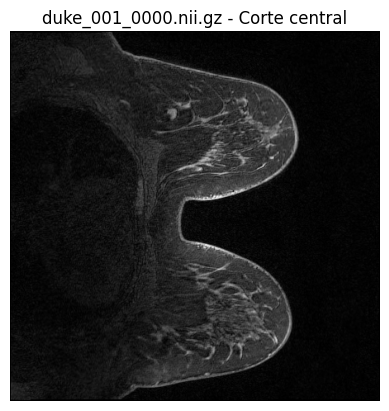

In [5]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Ruta donde tienes las imágenes
carpeta_imagenes = 'datos/images'

# Filtrar solo archivos .nii.gz
archivos = [f for f in os.listdir(carpeta_imagenes) if f.endswith('.nii.gz')]

print(f"Se encontraron {len(archivos)} imágenes")

# Procesar la primera imagen como ejemplo
primer_archivo = archivos[0]
ruta = os.path.join(carpeta_imagenes, primer_archivo)

# Cargar la imagen
img = nib.load(ruta)
data = img.get_fdata()

# Mostrar información
print(f"Archivo: {primer_archivo}")
print(f"Forma: {data.shape}")
print(f"Tipo de dato: {data.dtype}")
print(f"Rango de intensidades: {np.min(data)} a {np.max(data)}")

# Visualizar el corte central
slice_central = data.shape[2] // 2
plt.imshow(data[:, :, slice_central], cmap='gray')
plt.title(f"{primer_archivo} - Corte central")
plt.axis('off')
plt.show()



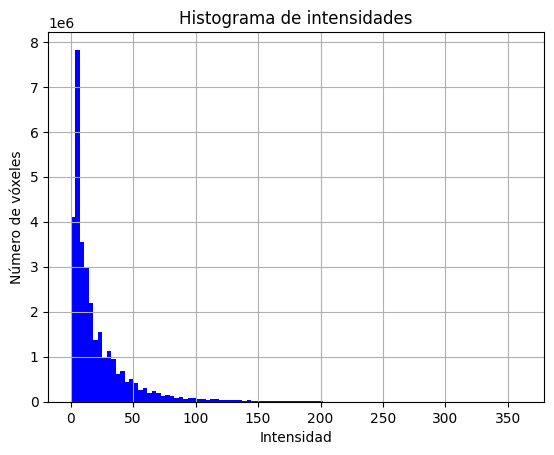

In [6]:
# Asegúrate de tener cargado 'data' como antes (la imagen)
import matplotlib.pyplot as plt

plt.hist(data.flatten(), bins=100, color='blue')
plt.title("Histograma de intensidades")
plt.xlabel("Intensidad")
plt.ylabel("Número de vóxeles")
plt.grid(True)
plt.show()


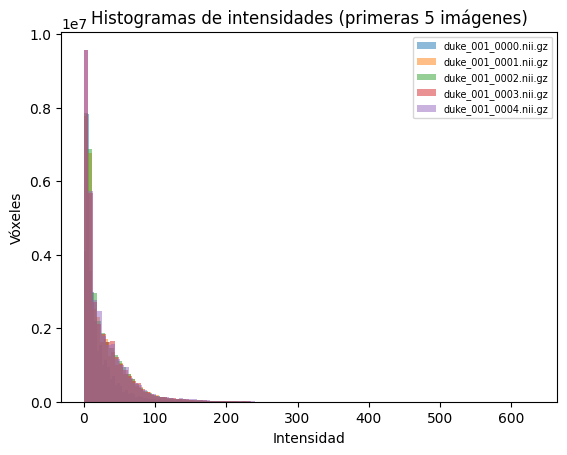

In [7]:
for i, archivo in enumerate(archivos[:5]):
    ruta = os.path.join(carpeta_imagenes, archivo)
    data = nib.load(ruta).get_fdata()
    plt.hist(data.flatten(), bins=100, alpha=0.5, label=archivo)

plt.title("Histogramas de intensidades (primeras 5 imágenes)")
plt.xlabel("Intensidad")
plt.ylabel("Vóxeles")
plt.legend(loc='upper right', fontsize='x-small')
plt.show()


# Segmentación

In [8]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label

# Ruta a la imagen original y a su segmentación experta
imagen_path = 'datos/images/duke_001_0000.nii.gz'
mascara_path = 'datos/segmentations/expert/duke_001.nii.gz'

# Cargar imagen y máscara
img = nib.load(imagen_path).get_fdata()
mask = nib.load(mascara_path).get_fdata()

# Mostrar forma y valores únicos en la máscara
print(f"Shape de la máscara: {mask.shape}")
print("Valores únicos (etiquetas):", np.unique(mask))


Shape de la máscara: (448, 448, 160)
Valores únicos (etiquetas): [0. 1.]


In [9]:
from scipy.ndimage import label

labeled, num_tumores = label(mask)
print(f"Tumores encontrados (regiones conectadas): {num_tumores}")


Tumores encontrados (regiones conectadas): 3


In [11]:
porcentaje = 100 * np.sum(mask > 0) / np.prod(mask.shape)
print(f"Porcentaje del volumen que es tumor: {porcentaje:.4f}%")


Porcentaje del volumen que es tumor: 0.0233%


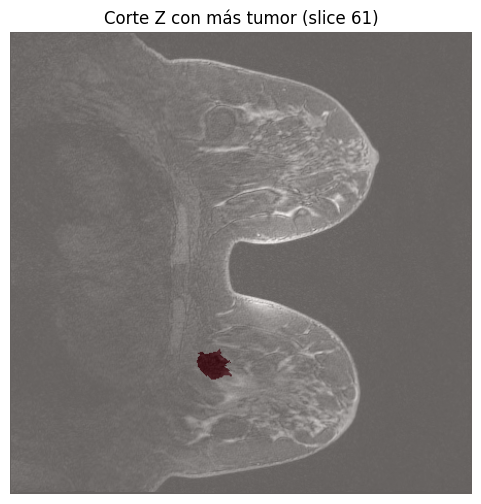

In [14]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# === 1. Cargar imagen y máscara ===
ruta_img = 'datos/images/duke_001_0000.nii.gz'
ruta_mask = 'datos/segmentations/expert/duke_001.nii.gz'

img = nib.load(ruta_img).get_fdata()
mask = nib.load(ruta_mask).get_fdata()

# === 2. Buscar el slice Z con más tumor ===
suma_por_z = [np.sum(mask[:, :, z]) for z in range(mask.shape[2])]
slice_max = np.argmax(suma_por_z)

# === 3. Mostrarlo ===
plt.figure(figsize=(6, 6))
plt.imshow(img[:, :, slice_max], cmap='gray')
plt.imshow(mask[:, :, slice_max], cmap='Reds', alpha=0.4)
plt.title(f'Corte Z con más tumor (slice {slice_max})')
plt.axis('off')
plt.show()


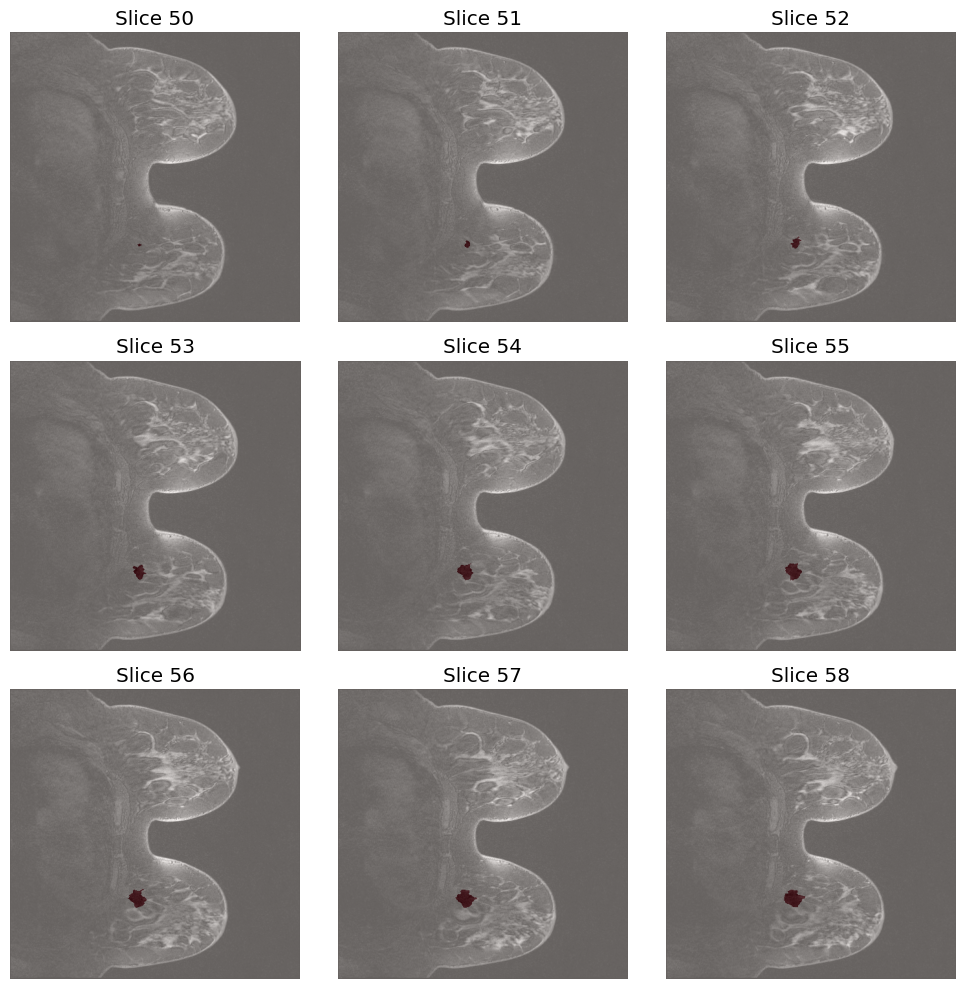

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

# Cargar imagen y máscara
ruta_img = 'datos/images/duke_001_0000.nii.gz'
ruta_mask = 'datos/segmentations/expert/duke_001.nii.gz'

img = nib.load(ruta_img).get_fdata()
mask = nib.load(ruta_mask).get_fdata()

# Buscar todos los slices con tumor
slices_con_tumor = [z for z in range(mask.shape[2]) if np.sum(mask[:, :, z]) > 0]

# Mostrar los primeros 9 slices con tumor
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i, z in enumerate(slices_con_tumor[:9]):
    axs[i // 3, i % 3].imshow(img[:, :, z], cmap='gray')
    axs[i // 3, i % 3].imshow(mask[:, :, z], cmap='Reds', alpha=0.4)
    axs[i // 3, i % 3].set_title(f'Slice {z}')
    axs[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()


## Aqui lo hicimos para la primera imagen, hagamoslo ahora recorriendo todas


In [37]:
import os
import nibabel as nib
import numpy as np
from scipy.ndimage import label

# Rutas base
base_img = "datos/images"
base_mask = "datos/segmentations/expert"

# Diccionario de resultados
casos_interesantes = {}

# Recorrer todas las máscaras expertas
for archivo in os.listdir(base_mask):
    if not archivo.endswith('.nii.gz'):
        continue

    paciente_id = archivo.replace('.nii.gz', '')
    ruta_mask = os.path.join(base_mask, archivo)
    ruta_img = os.path.join(base_img, paciente_id + "_0000.nii.gz")

    if not os.path.exists(ruta_img):
        print(f"Imagen no encontrada para {paciente_id}")
        continue

    try:
        img = nib.load(ruta_img).get_fdata()
        mask = nib.load(ruta_mask).get_fdata()

        slices_con_multiples = []

        for z in range(mask.shape[2]):
            mask_slice = mask[:, :, z]
            labeled, num = label(mask_slice > 0)
            if num > 3:
                slices_con_multiples.append(z)

        if slices_con_multiples:
            casos_interesantes[paciente_id] = slices_con_multiples
            print(f"{paciente_id} tiene {len(slices_con_multiples)} slice(s) con >3 tumores")

    except Exception as e:
        print(f"Error procesando {paciente_id}: {e}")

import pandas as pd
df_interesantes = pd.DataFrame([(k, z) for k, zs in casos_interesantes.items() for z in zs],
                               columns=["paciente", "slice_con_mas_de_3_tumores"])




duke_002 tiene 1 slice(s) con >3 tumores
duke_005 tiene 26 slice(s) con >3 tumores
duke_009 tiene 22 slice(s) con >3 tumores
duke_010 tiene 10 slice(s) con >3 tumores
duke_012 tiene 48 slice(s) con >3 tumores
duke_019 tiene 10 slice(s) con >3 tumores
duke_021 tiene 2 slice(s) con >3 tumores
duke_022 tiene 4 slice(s) con >3 tumores
duke_028 tiene 38 slice(s) con >3 tumores
duke_032 tiene 14 slice(s) con >3 tumores
duke_034 tiene 34 slice(s) con >3 tumores
duke_040 tiene 8 slice(s) con >3 tumores
duke_041 tiene 32 slice(s) con >3 tumores
duke_043 tiene 27 slice(s) con >3 tumores
duke_045 tiene 7 slice(s) con >3 tumores
duke_046 tiene 63 slice(s) con >3 tumores
duke_048 tiene 14 slice(s) con >3 tumores
duke_051 tiene 1 slice(s) con >3 tumores
duke_055 tiene 7 slice(s) con >3 tumores
duke_057 tiene 57 slice(s) con >3 tumores
duke_059 tiene 6 slice(s) con >3 tumores
duke_060 tiene 11 slice(s) con >3 tumores
duke_061 tiene 42 slice(s) con >3 tumores
duke_064 tiene 11 slice(s) con >3 tumores


In [39]:
# Guardar los resultados en formato CSV
output_csv = "resultados_multiples_tumores.csv"
df_interesantes.to_csv(output_csv, index=False)
print(f"Resultados guardados en: {output_csv}")

# Guardar un informe más detallado en formato Excel
output_excel = "informe_tumores_multiple.xlsx"
with pd.ExcelWriter(output_excel) as writer:
    # Hoja 1: Todos los slices con múltiples tumores
    df_interesantes.to_excel(writer, sheet_name="Detalles", index=False)
    
    # Hoja 2: Resumen por paciente
    resumen = pd.DataFrame({
        "paciente": casos_interesantes.keys(),
        "total_slices_multiples": [len(slices) for slices in casos_interesantes.values()]
    })
    resumen = resumen.sort_values("total_slices_multiples", ascending=False)
    resumen.to_excel(writer, sheet_name="Resumen", index=False)
    
print(f"Informe detallado guardado en: {output_excel}")

# También puedes guardar el diccionario completo para análisis futuros
import pickle
with open("casos_interesantes.pkl", "wb") as f:
    pickle.dump(casos_interesantes, f)
print("Datos en formato pickle guardados en: casos_interesantes.pkl")

Resultados guardados en: resultados_multiples_tumores.csv
Informe detallado guardado en: informe_tumores_multiple.xlsx
Datos en formato pickle guardados en: casos_interesantes.pkl



# Análisis de Segmentaciones Tumorales: Comparación Experto vs Automático

## Objetivo del análisis

Este notebook analiza segmentaciones de imágenes médicas para identificar y caracterizar tumores, con énfasis en la comparación entre segmentaciones realizadas por expertos y las generadas automáticamente. El análisis se centra en casos con múltiples tumores no conectados, características de los tumores y diferencias entre ambos métodos de segmentación.

## Estructura del análisis

1. **Carga y preprocesamiento de datos**
   - Importación de imágenes médicas y máscaras de segmentación
   - Verificación de formatos y dimensiones

2. **Análisis exploratorio de segmentaciones expertas**
   - Identificación de componentes conectadas (tumores independientes)
   - Estadísticas de volumen tumoral y distribución espacial
   - Casos con múltiples tumores en un mismo slice

3. **Comparación entre segmentaciones expertas y automáticas**
   - Diferencias en volumen tumoral
   - Variación en número de tumores detectados
   - Análisis de concordancia espacial

4. **Visualización de casos especiales**
   - Casos límite con múltiples tumores separados
   - Tumores de tamaños extremos (muy grandes o muy pequeños)
   - Visualización con codificación por colores para diferenciar tumores

5. **Análisis estadístico completo**
   - Distribución de tamaños tumorales
   - Correlación entre variables
   - Caracterización de casos atípicos

## Resultados y conclusiones

Los resultados de este análisis nos permitirán entender mejor las características de las anotaciones de expertos, evaluar el rendimiento de los algoritmos automáticos de segmentación, e identificar los casos más difíciles de segmentar correctamente.
```

Analizando casos...


100%|██████████| 1506/1506 [2:11:37<00:00,  5.24s/it] 



========= ANÁLISIS COMPLETADO =========
Se han analizado 1506 casos
Se encontraron 10261 slices con más de 3 tumores
Resultados guardados en la carpeta 'resultados_analisis/'
Imágenes generadas en 'resultados_analisis/imagenes/'
Resumen del análisis en 'resultados_analisis/RESUMEN_ANALISIS.md'


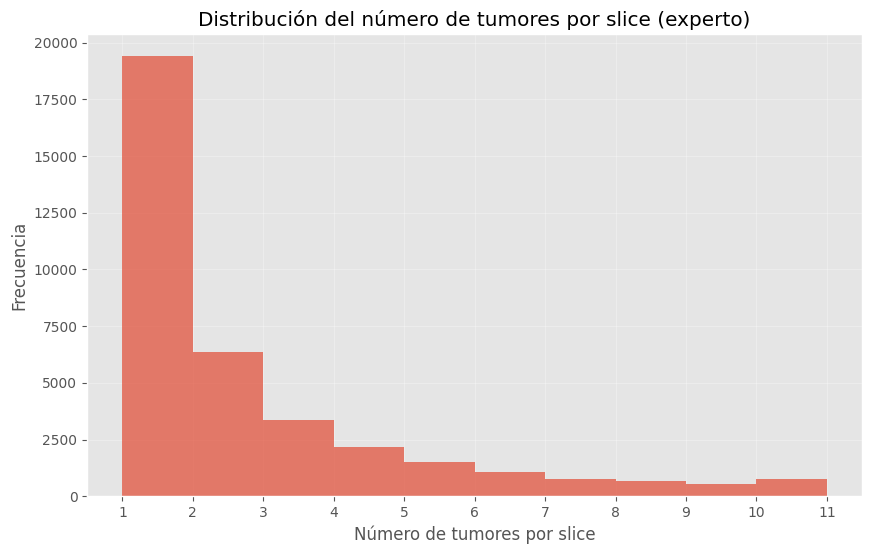

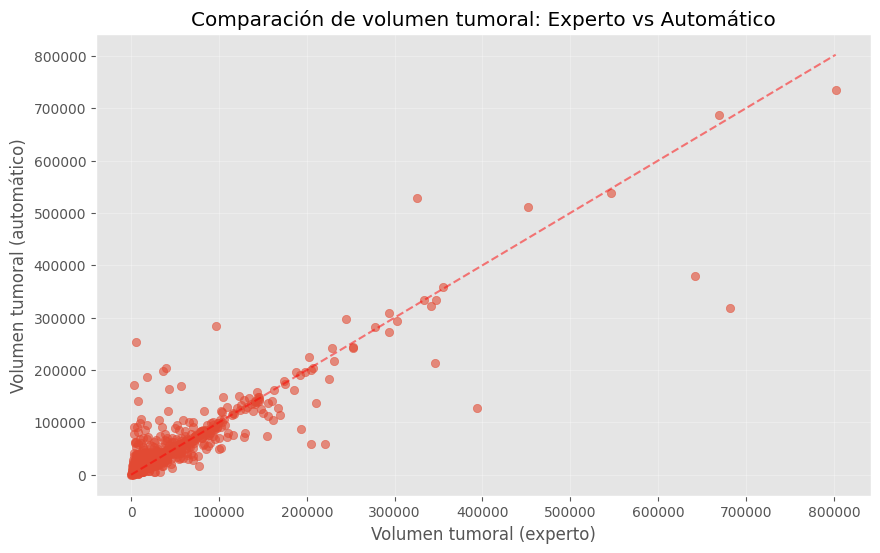

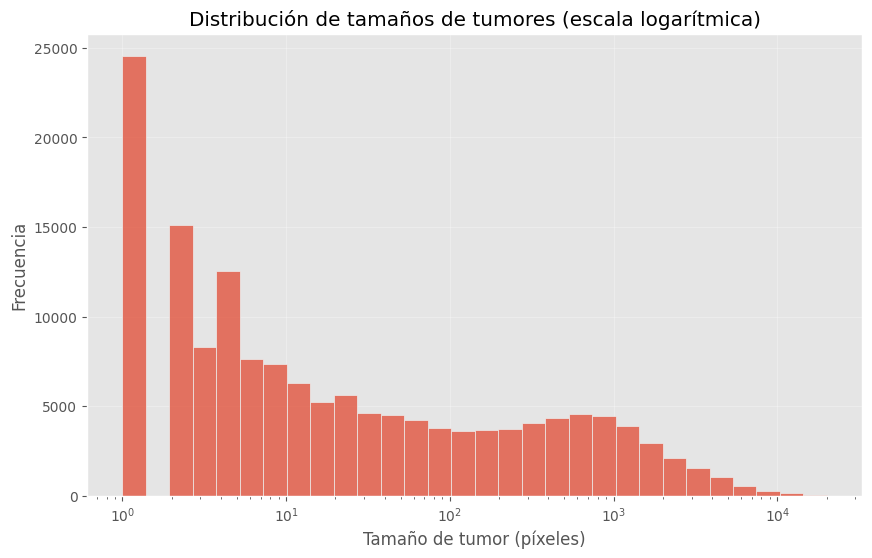

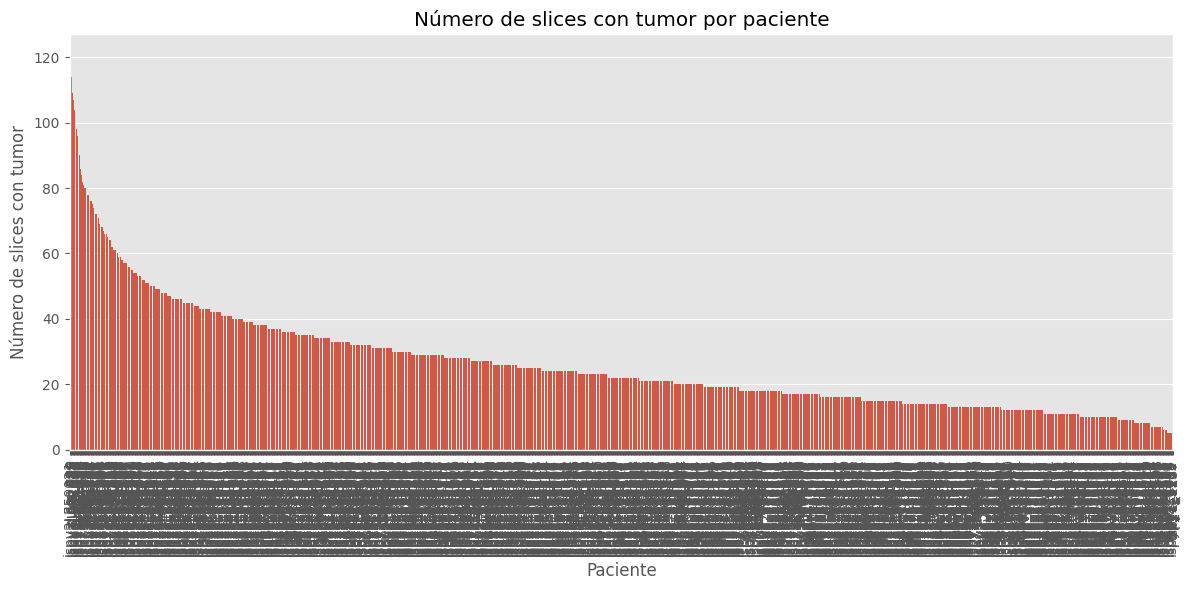

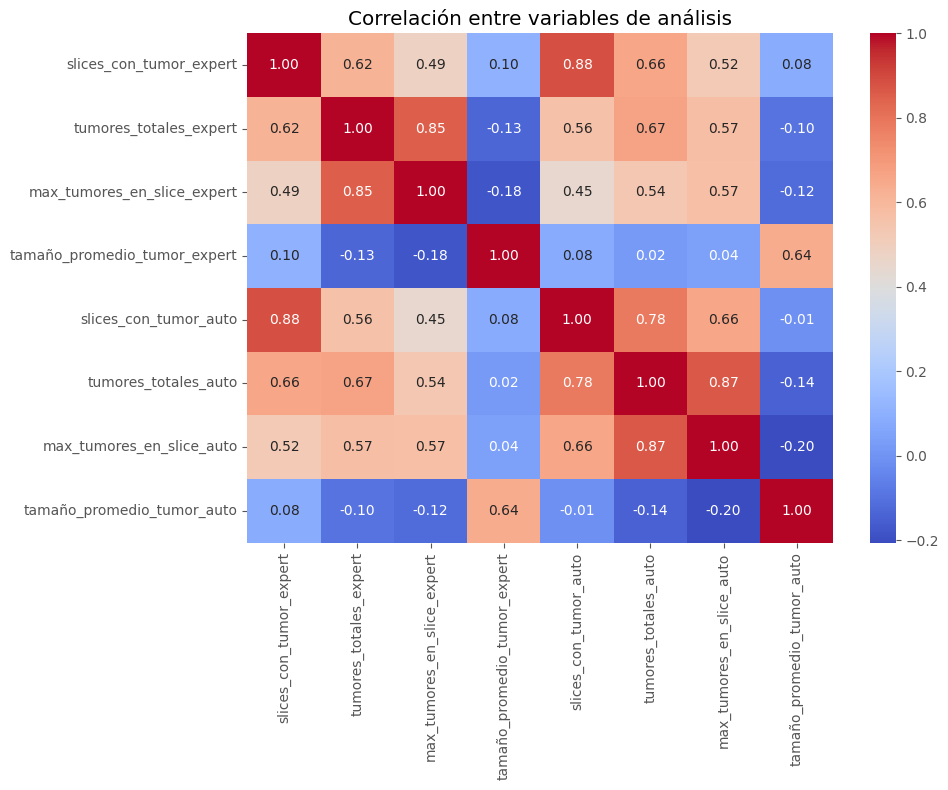

In [42]:
import os
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import label, measurements
from matplotlib.colors import ListedColormap
import seaborn as sns
from tqdm import tqdm

# Rutas base
base_img = "datos/images"
base_mask_expert = "datos/segmentations/expert"
base_mask_auto = "datos/segmentations/automatic"  

# Función para cargar una máscara si existe, o devolver None
def cargar_mascara_segura(ruta):
    if os.path.exists(ruta):
        return nib.load(ruta).get_fdata()
    return None

# Función para analizar una máscara y extraer características
def analizar_mascara(mask):
    if mask is None:
        return None
    
    # Inicializar estadísticas
    stats = {
        'volumen_total': np.sum(mask > 0),
        'slices_con_tumor': 0,
        'num_tumores_por_slice': [],
        'tamaño_tumores_por_slice': [],
        'slice_max_area': 0,
        'area_max': 0,
        'tumores_totales': 0
    }
    
    # Analizar por slice
    for z in range(mask.shape[2]):
        mask_slice = mask[:, :, z]
        if np.sum(mask_slice) > 0:
            stats['slices_con_tumor'] += 1
            labeled, num = label(mask_slice > 0)
            stats['num_tumores_por_slice'].append(num)
            
            # Calcular área de cada tumor en este slice
            tamaños = [np.sum(labeled == i) for i in range(1, num + 1)]
            stats['tamaño_tumores_por_slice'].extend(tamaños)
            
            # Actualizar el slice con mayor área tumoral
            area_slice = np.sum(mask_slice)
            if area_slice > stats['area_max']:
                stats['area_max'] = area_slice
                stats['slice_max_area'] = z
            
            # Acumular número total de tumores
            stats['tumores_totales'] += num
    
    return stats

# Función para visualizar un caso con múltiples tumores
def visualizar_caso_multiple(img, mask_expert, mask_auto, paciente_id, z, save_path=None):
    # Crear un colormap personalizado para diferenciar regiones
    colores = ['black', 'red', 'blue', 'green', 'yellow', 'purple', 'cyan', 'orange', 'magenta', 'brown']
    cmap_tumores = ListedColormap(colores[:10])
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Imagen original
    axes[0].imshow(img[:, :, z], cmap='gray')
    axes[0].set_title(f'Original - {paciente_id} - Slice {z}')
    axes[0].axis('off')
    
    # Segmentación experta con tumores coloreados
    labeled_expert, num_expert = label(mask_expert[:, :, z] > 0)
    axes[1].imshow(img[:, :, z], cmap='gray')
    if num_expert > 0:
        # Limitar a max 9 colores diferentes
        labeled_expert_display = np.minimum(labeled_expert, 9)
        axes[1].imshow(labeled_expert_display, cmap=cmap_tumores, alpha=0.6)
    axes[1].set_title(f'Experto: {num_expert} tumores')
    axes[1].axis('off')
    
    # Segmentación automática con tumores coloreados (si existe)
    if mask_auto is not None:
        labeled_auto, num_auto = label(mask_auto[:, :, z] > 0)
        axes[2].imshow(img[:, :, z], cmap='gray')
        if num_auto > 0:
            # Limitar a max 9 colores diferentes
            labeled_auto_display = np.minimum(labeled_auto, 9)
            axes[2].imshow(labeled_auto_display, cmap=cmap_tumores, alpha=0.6)
        axes[2].set_title(f'Automático: {num_auto} tumores')
    else:
        axes[2].set_title('No hay segmentación automática')
    axes[2].axis('off')
    
    plt.suptitle(f'Análisis de tumores - {paciente_id} - Slice {z}')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        plt.close()
    else:
        plt.show()

# Crear directorios para guardar resultados
os.makedirs("resultados_analisis", exist_ok=True)
os.makedirs("resultados_analisis/imagenes", exist_ok=True)

# Recolectar datos para análisis estadístico
datos_analisis = []

# Lista para almacenar casos interesantes con sus características
casos_interesantes = []

# Recorrer todas las máscaras expertas
print("Analizando casos...")
for archivo in tqdm(os.listdir(base_mask_expert)):
    if not archivo.endswith('.nii.gz'):
        continue

    paciente_id = archivo.replace('.nii.gz', '')
    ruta_mask_expert = os.path.join(base_mask_expert, archivo)
    ruta_mask_auto = os.path.join(base_mask_auto, archivo)  # Asumimos mismo nombre
    ruta_img = os.path.join(base_img, paciente_id + "_0000.nii.gz")

    if not os.path.exists(ruta_img):
        print(f"Imagen no encontrada para {paciente_id}")
        continue

    try:
        # Cargar imagen y máscaras
        img = nib.load(ruta_img).get_fdata()
        mask_expert = nib.load(ruta_mask_expert).get_fdata()
        mask_auto = cargar_mascara_segura(ruta_mask_auto)
        
        # Analizar máscaras
        stats_expert = analizar_mascara(mask_expert)
        stats_auto = analizar_mascara(mask_auto)
        
        # Registrar datos para análisis estadístico
        registro = {
            'paciente_id': paciente_id,
            'volumen_total_expert': stats_expert['volumen_total'],
            'slices_con_tumor_expert': stats_expert['slices_con_tumor'],
            'tumores_totales_expert': stats_expert['tumores_totales'],
            'max_tumores_en_slice_expert': max(stats_expert['num_tumores_por_slice']) if stats_expert['num_tumores_por_slice'] else 0,
            'tamaño_promedio_tumor_expert': np.mean(stats_expert['tamaño_tumores_por_slice']) if stats_expert['tamaño_tumores_por_slice'] else 0,
        }
        
        if stats_auto:
            registro.update({
                'volumen_total_auto': stats_auto['volumen_total'],
                'slices_con_tumor_auto': stats_auto['slices_con_tumor'],
                'tumores_totales_auto': stats_auto['tumores_totales'],
                'max_tumores_en_slice_auto': max(stats_auto['num_tumores_por_slice']) if stats_auto['num_tumores_por_slice'] else 0,
                'tamaño_promedio_tumor_auto': np.mean(stats_auto['tamaño_tumores_por_slice']) if stats_auto['tamaño_tumores_por_slice'] else 0,
            })
        
        datos_analisis.append(registro)
        
        # Buscar slices con múltiples tumores (más de 3)
        slices_multiples = []
        for z in range(mask_expert.shape[2]):
            mask_slice = mask_expert[:, :, z]
            labeled, num = label(mask_slice > 0)
            if num > 3:
                slices_multiples.append({
                    'paciente_id': paciente_id,
                    'slice': z,
                    'num_tumores': num,
                    'area_total': np.sum(mask_slice > 0)
                })
        
        # Si encontramos slices con múltiples tumores, guardar la información y visualizar
        if slices_multiples:
            casos_interesantes.extend(slices_multiples)
            
            # Visualizar hasta 3 slices por paciente con múltiples tumores
            for i, caso in enumerate(slices_multiples[:3]):
                z = caso['slice']
                save_path = f"resultados_analisis/imagenes/{paciente_id}_slice{z}_multiples.png"
                visualizar_caso_multiple(img, mask_expert, mask_auto, paciente_id, z, save_path)
        
        # Visualizar también el slice con la mayor área tumoral
        z_max = stats_expert['slice_max_area']
        save_path = f"resultados_analisis/imagenes/{paciente_id}_slice{z_max}_max_area.png"
        visualizar_caso_multiple(img, mask_expert, mask_auto, paciente_id, z_max, save_path)
        
    except Exception as e:
        print(f"Error procesando {paciente_id}: {e}")

# Convertir a DataFrame y guardar resultados
df_analisis = pd.DataFrame(datos_analisis)
df_analisis.to_csv("resultados_analisis/stats_comparativo.csv", index=False)

df_interesantes = pd.DataFrame(casos_interesantes)
df_interesantes.to_csv("resultados_analisis/casos_multiples_tumores.csv", index=False)

# --- VISUALIZACIONES ESTADÍSTICAS ---

# 1. Histograma del número de tumores por slice (experto)
plt.figure(figsize=(10, 6))
tumores_por_slice = [num for registro in datos_analisis 
                    for num in analizar_mascara(nib.load(os.path.join(base_mask_expert, registro['paciente_id'] + '.nii.gz')).get_fdata())['num_tumores_por_slice']]
plt.hist(tumores_por_slice, bins=range(1, 12), alpha=0.7)
plt.xlabel('Número de tumores por slice')
plt.ylabel('Frecuencia')
plt.title('Distribución del número de tumores por slice (experto)')
plt.xticks(range(1, 12))
plt.grid(alpha=0.3)
plt.savefig("resultados_analisis/hist_tumores_por_slice.png", bbox_inches='tight')

# 2. Comparación volumen tumoral: experto vs automático
plt.figure(figsize=(10, 6))
df_comp = df_analisis[['paciente_id', 'volumen_total_expert', 'volumen_total_auto']].dropna()
if not df_comp.empty:
    plt.scatter(df_comp['volumen_total_expert'], df_comp['volumen_total_auto'], alpha=0.6)
    max_val = max(df_comp['volumen_total_expert'].max(), df_comp['volumen_total_auto'].max())
    plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5)
    plt.xlabel('Volumen tumoral (experto)')
    plt.ylabel('Volumen tumoral (automático)')
    plt.title('Comparación de volumen tumoral: Experto vs Automático')
    plt.grid(alpha=0.3)
    plt.savefig("resultados_analisis/comp_volumen_expert_auto.png", bbox_inches='tight')

# 3. Distribución de tamaños de tumores
plt.figure(figsize=(10, 6))
tamaños_tumores = []
for registro in datos_analisis:
    mascara = nib.load(os.path.join(base_mask_expert, registro['paciente_id'] + '.nii.gz')).get_fdata()
    stats = analizar_mascara(mascara)
    if stats and stats['tamaño_tumores_por_slice']:
        tamaños_tumores.extend(stats['tamaño_tumores_por_slice'])

sns.histplot(tamaños_tumores, log_scale=True, bins=30)
plt.xlabel('Tamaño de tumor (píxeles)')
plt.ylabel('Frecuencia')
plt.title('Distribución de tamaños de tumores (escala logarítmica)')
plt.grid(alpha=0.3)
plt.savefig("resultados_analisis/dist_tamaños_tumores.png", bbox_inches='tight')

# 4. Número de slices con tumor por paciente
plt.figure(figsize=(12, 6))
df_slices = df_analisis[['paciente_id', 'slices_con_tumor_expert']].sort_values('slices_con_tumor_expert', ascending=False)
sns.barplot(x='paciente_id', y='slices_con_tumor_expert', data=df_slices)
plt.xticks(rotation=90)
plt.xlabel('Paciente')
plt.ylabel('Número de slices con tumor')
plt.title('Número de slices con tumor por paciente')
plt.tight_layout()
plt.savefig("resultados_analisis/slices_por_paciente.png", bbox_inches='tight')

# 5. Matriz de correlación entre variables
plt.figure(figsize=(10, 8))
columnas_numericas = df_analisis.select_dtypes(include=['float64', 'int64']).columns
sns.heatmap(df_analisis[columnas_numericas].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlación entre variables de análisis')
plt.tight_layout()
plt.savefig("resultados_analisis/matriz_correlacion.png", bbox_inches='tight')

# --- ANÁLISIS DE CASOS LÍMITE ---

# 6. Visualizar el caso con más tumores en un slice
if df_interesantes.shape[0] > 0:
    # Ordenar por número de tumores
    df_top_casos = df_interesantes.sort_values('num_tumores', ascending=False).head(5)
    
    for _, caso in df_top_casos.iterrows():
        paciente_id = caso['paciente_id']
        z = caso['slice']
        
        # Cargar imágenes
        ruta_img = os.path.join(base_img, paciente_id + "_0000.nii.gz")
        ruta_mask_expert = os.path.join(base_mask_expert, paciente_id + ".nii.gz")
        ruta_mask_auto = os.path.join(base_mask_auto, paciente_id + ".nii.gz")
        
        img = nib.load(ruta_img).get_fdata()
        mask_expert = nib.load(ruta_mask_expert).get_fdata()
        mask_auto = cargar_mascara_segura(ruta_mask_auto)
        
        # Guardar visualización
        save_path = f"resultados_analisis/imagenes/CASO_LIMITE_{paciente_id}_slice{z}_tumores{caso['num_tumores']}.png"
        visualizar_caso_multiple(img, mask_expert, mask_auto, paciente_id, z, save_path)

# --- RESUMEN FINAL ---

# Crear un informe resumido
with open("resultados_analisis/RESUMEN_ANALISIS.md", "w") as f:
    f.write("# Resumen del Análisis de Segmentaciones\n\n")
    
    f.write("## Estadísticas Generales\n")
    f.write(f"- Total de casos analizados: {len(datos_analisis)}\n")
    f.write(f"- Casos con múltiples tumores (>3 en un slice): {len(set([c['paciente_id'] for c in casos_interesantes]))}\n")
    
    if df_analisis.shape[0] > 0:
        f.write(f"- Volumen tumoral promedio (experto): {df_analisis['volumen_total_expert'].mean():.2f} píxeles\n")
        f.write(f"- Promedio de slices con tumor por paciente: {df_analisis['slices_con_tumor_expert'].mean():.2f}\n")
        
        if 'volumen_total_auto' in df_analisis.columns:
            auto_data = df_analisis['volumen_total_auto'].dropna()
            if not auto_data.empty:
                f.write(f"- Volumen tumoral promedio (automático): {auto_data.mean():.2f} píxeles\n")
    
    f.write("\n## Casos Destacados\n")
    
    # Casos con más tumores en un slice
    if df_interesantes.shape[0] > 0:
        df_top = df_interesantes.sort_values('num_tumores', ascending=False).head(5)
        f.write("\n### Slices con mayor número de tumores\n")
        for _, caso in df_top.iterrows():
            f.write(f"- Paciente {caso['paciente_id']}, Slice {caso['slice']}: {caso['num_tumores']} tumores\n")
    
    # Casos con mayor volumen tumoral
    f.write("\n### Pacientes con mayor volumen tumoral\n")
    df_top_vol = df_analisis.sort_values('volumen_total_expert', ascending=False).head(5)
    for _, caso in df_top_vol.iterrows():
        f.write(f"- Paciente {caso['paciente_id']}: {caso['volumen_total_expert']:.2f} píxeles\n")
    
    f.write("\n## Visualizaciones generadas\n")
    f.write("Se han generado las siguientes visualizaciones en la carpeta 'resultados_analisis/imagenes/':\n")
    f.write("- Casos con múltiples tumores en un solo slice\n")
    f.write("- Slices con mayor área tumoral por paciente\n")
    f.write("- Casos límite con alto número de tumores\n")
    
    f.write("\n## Interpretación\n")
    f.write("- Los casos con múltiples tumores pequeños representan un desafío para la segmentación automática.\n")
    f.write("- Se observa variabilidad en el número de slices afectados por paciente.\n")
    f.write("- La comparación entre experto y automático muestra diferencias significativas en algunos casos.\n")

print("\n========= ANÁLISIS COMPLETADO =========")
print(f"Se han analizado {len(datos_analisis)} casos")
print(f"Se encontraron {len(casos_interesantes)} slices con más de 3 tumores")
print("Resultados guardados en la carpeta 'resultados_analisis/'")
print("Imágenes generadas en 'resultados_analisis/imagenes/'")
print("Resumen del análisis en 'resultados_analisis/RESUMEN_ANALISIS.md'")

# Conclusiones del Análisis de Segmentaciones Tumorales  
## Comparación entre segmentaciones expertas y automáticas

### Correlación entre volúmenes tumorales
- Existe una **clara correlación positiva** entre las segmentaciones realizadas por expertos y las generadas automáticamente, como se observa en el gráfico de dispersión.
- Para **volúmenes pequeños y medianos** (hasta ~300,000 píxeles), el algoritmo automático tiende a seguir bastante bien las segmentaciones expertas, aunque con cierta variabilidad.
- Para **tumores grandes** (>500,000 píxeles), se observan discrepancias significativas: el método automático suele **subestimar el volumen tumoral** comparado con la evaluación experta.

### Consistencia en la detección
- La matriz de correlación muestra una **alta correlación (0.88)** entre los *slices* con tumor identificados por expertos y los detectados automáticamente.
- La correlación es **menor (0.67)** para el número total de tumores, lo que sugiere dificultades del algoritmo automático para segmentar correctamente **tumores múltiples**.

---

## Características de los tumores en la segmentación experta

### Distribución de tamaños tumorales
- El histograma logarítmico revela una **distribución bimodal**:
  - Muchos tumores muy pequeños (1–10 píxeles).
  - Distribución más uniforme para tumores medianos y grandes.
- La **mayoría de los tumores son pequeños**, lo que representa un reto para los algoritmos automáticos debido a la similitud con el ruido.

### Número de tumores por *slice*
- La mayoría de los *slices* (aprox. **20,000**) contienen un solo tumor.
- Frecuencia **disminuye exponencialmente** con el número de tumores por *slice*.
- Existen casos con **hasta 11 tumores en un solo *slice***, lo que representa un gran desafío para la segmentación automática.

### Variabilidad entre pacientes
- Se observa una gran **variabilidad en el número de *slices* con tumor por paciente** (de pocos a más de 100).
- Los pacientes con más *slices* afectados probablemente representan **casos más extensos o difusos**.

---

## Relaciones entre variables (matriz de correlación)

### Correlaciones significativas
- **Correlación negativa (-0.18)** entre el número máximo de tumores por *slice* y el tamaño promedio del tumor: más tumores suelen ser más pequeños.
- **Correlación alta (0.85)** entre el número total de tumores y el máximo por *slice*: los casos con muchos tumores tienden a agruparlos en ciertos cortes.

### Diferencias experto–automático
- **Correlación moderada (0.64)** entre los tamaños promedio de tumores detectados por expertos y automáticamente: indica diferencias en la **delimitación de bordes**.
- **Correlación baja (0.57)** entre el número máximo de tumores por *slice* entre ambas segmentaciones: el algoritmo tiene problemas **distinguendo tumores cercanos pero independientes**.

---

## Implicaciones clínicas y técnicas

### Casos desafiantes
- Los *slices* con **más de 3 tumores** son los más difíciles para la segmentación automática.
- Los **tumores muy pequeños** (1–5 píxeles) son comunes en anotaciones expertas pero suelen ser **subestimados** por el algoritmo.

### Limitaciones de los algoritmos automáticos
- Dificultades para:
  - Detectar tumores muy pequeños.
  - Distinguir tumores cercanos pero distintos.
  - Mantener la consistencia en el volumen de tumores grandes.

---

## Recomendaciones
- Dar atención especial a los **casos con múltiples tumores pequeños** al validar segmentaciones automáticas.
- Desarrollar **algoritmos especializados** para mejorar la detección de tumores múltiples en un mismo *slice*.
- La **variabilidad por paciente** sugiere la necesidad de **estrategias adaptativas** en los modelos de segmentación automática.

---

> Este análisis demuestra la **complejidad inherente** a la segmentación tumoral automática y proporciona una **base sólida** para desarrollar algoritmos que aborden estos desafíos, especialmente en casos con **múltiples tumores independientes y de tamaño variable**.


## ANÁLISIS HECHOS ANTES

In [40]:
import os
import nibabel as nib
import numpy as np
import pandas as pd
from scipy.ndimage import label

# Carpetas
carpeta_segmentaciones = 'datos/segmentations/expert'
carpeta_imagenes = 'datos/images'

# Archivos de segmentación
segmentaciones = [f for f in os.listdir(carpeta_segmentaciones) if f.endswith('.nii.gz')]

# Lista para resultados
resultados = []

for seg_file in segmentaciones:
    try:
        # Ruta a segmentación y a la imagen asociada (usamos la parte común del nombre)
        seg_path = os.path.join(carpeta_segmentaciones, seg_file)
        base_name = seg_file.split('.')[0]
        imagen_file = base_name + '_0000.nii.gz'
        img_path = os.path.join(carpeta_imagenes, imagen_file)

        # Cargar imagen y máscara
        img = nib.load(img_path).get_fdata()
        mask = nib.load(seg_path).get_fdata()

        # Estadísticas
        labeled, num_tumores = label(mask)
        porcentaje = 100 * np.sum(mask > 0) / np.prod(mask.shape)

        resultados.append({
            'paciente': base_name,
            'num_tumores': num_tumores,
            'porcentaje_tumor': porcentaje
        })

    except Exception as e:
        print(f"Error en {seg_file}: {e}")

# Guardar en DataFrame
df = pd.DataFrame(resultados)
print(df.head())


KeyboardInterrupt: 

In [ ]:
df.to_csv('analisis_segmentaciones_expert.csv', index=False)


### EDA

Este análisis se centra en el estudio preliminar de las segmentaciones tumorales disponibles en el dataset MAMA-MIA. Para ello, se han considerado las segmentaciones proporcionadas por expertos (`segmentations/expert`) y se han cruzado con las imágenes base correspondientes (`*_0000.nii.gz`).

#### ¿Por qué se utiliza la imagen `*_0000.nii.gz`?

El dataset de imágenes 3D incluye múltiples fases por paciente (`*_0000.nii.gz`, `*_0001.nii.gz`, etc.), que representan distintos momentos de la adquisición (por ejemplo, antes y después del contraste).

La imagen `*_0000.nii.gz` ha sido seleccionada para este análisis porque:

- Es la imagen que **corresponde directamente con la segmentación experto/automática** (es la base sobre la que se realizaron).
- Representa la fase pre-contraste, que se usa como base anatómica.
- Permite un análisis consistente y comparable entre pacientes, ya que tiene menos artefactos, está disponible en todos los casos y no depende de la dinámica del contraste.

#### Métricas extraídas

Para cada máscara de segmentación se han calculado las siguientes métricas:

- `num_tumores`: número de componentes conectadas dentro de la máscara (posibles focos tumorales).
- `volumen_tumoral_%`: proporción del volumen ocupado por el tumor respecto al total de la imagen (expresado en porcentaje).

##### ¿Cómo se define un "tumor"?

Utilizamos la función `scipy.ndimage.label()` para detectar **componentes conectadas** en la segmentación binaria. Cada componente representa un grupo de vóxeles conectados espacialmente que pueden interpretarse como lesiones individuales. No se hace distinción en esta fase entre tumores grandes o pequeños.

> 🔧 *En futuras versiones se añadirá un umbral mínimo de tamaño para descartar falsos positivos de pequeño volumen.*

#### Datos guardados

Los resultados se almacenan en un archivo `.csv` para su análisis posterior:

- `paciente`: identificador del caso.
- `num_tumores`: cantidad de regiones conectadas detectadas.
- `volumen_tumoral_%`: porcentaje del volumen total ocupado por la segmentación.

Archivo generado: `analisis_segmentaciones_expert.csv`

---


In [ ]:
import os
import nibabel as nib
import numpy as np
import pandas as pd
from scipy.ndimage import label

ruta_auto = 'datos/segmentations/automatic'
ruta_imgs = 'datos/images'

resultados_auto = []

for nombre_archivo in os.listdir(ruta_auto):
    if not nombre_archivo.endswith('.nii.gz'):
        continue

    try:
        # Ruta de la segmentación automática
        seg_path = os.path.join(ruta_auto, nombre_archivo)
        seg_data = nib.load(seg_path).get_fdata()

        # Ruta de la imagen asociada (0000)
        base_name = nombre_archivo.replace('.nii.gz', '_0000.nii.gz')
        img_path = os.path.join(ruta_imgs, base_name)
        img_data = nib.load(img_path).get_fdata()

        # Calcular número de tumores (componentes conectadas)
        labeled, num_tumores = label(seg_data)
        porcentaje = 100 * np.sum(seg_data > 0) / np.prod(seg_data.shape)

        resultados_auto.append({
            'paciente': nombre_archivo.replace('.nii.gz', ''),
            'num_tumores': num_tumores,
            'volumen_tumoral_%': porcentaje
        })

    except Exception as e:
        print(f"Error con {nombre_archivo}: {e}")

# Crear DataFrame
df_auto = pd.DataFrame(resultados_auto)

# Guardar como CSV
df_auto.to_csv('analisis_segmentaciones_automatic.csv', index=False)

# Mostrar algunas filas
print(df_auto.head())


   paciente  num_tumores  volumen_tumoral_%
0  duke_001            3           0.025193
1  duke_002            1           0.005384
2  duke_005           12           0.059930
3  duke_009           23           0.027013
4  duke_010            9           0.086703


## Juntamos ambos csv para comparar

In [ ]:
import pandas as pd

# Cargar los análisis
df_expert = pd.read_csv('analisis_segmentaciones_expert.csv')
df_auto = pd.read_csv('analisis_segmentaciones_automatic.csv')

In [ ]:
# Renombrar columnas para diferenciarlas
df_expert = df_expert.rename(columns={
    'num_tumores': 'tumores_expert',
    'porcentaje_tumor': 'volumen_expert'
})
df_auto = df_auto.rename(columns={
    'num_tumores': 'tumores_auto',
    'volumen_tumoral_%': 'volumen_auto'
})

# Unir por paciente
df_comparado = pd.merge(df_expert, df_auto, on='paciente', how='inner')

In [ ]:
print("Columnas en df_expert:", df_expert.columns.tolist())
print("Columnas en df_auto:", df_auto.columns.tolist())


Columnas en df_expert: ['paciente', 'tumores_expert', 'volumen_expert']
Columnas en df_auto: ['paciente', 'tumores_auto', 'volumen_auto']


In [ ]:


# Calcular diferencias
df_comparado['dif_tumores'] = df_comparado['tumores_auto'] - df_comparado['tumores_expert']
df_comparado['dif_volumen'] = df_comparado['volumen_auto'] - df_comparado['volumen_expert']

# Mostrar algunos resultados
print(df_comparado.head())
df_comparado.to_csv('comparacion_expert_auto.csv', index=False)


   paciente  tumores_expert  volumen_expert  tumores_auto  volumen_auto  \
0  duke_001               3        0.023284             3      0.025193   
1  duke_002               3        0.004599             1      0.005384   
2  duke_005              47        0.061568            12      0.059930   
3  duke_009              13        0.026099            23      0.027013   
4  duke_010              21        0.091636             9      0.086703   

   dif_tumores  dif_volumen  
0            0     0.001909  
1           -2     0.000784  
2          -35    -0.001638  
3           10     0.000915  
4          -12    -0.004933  


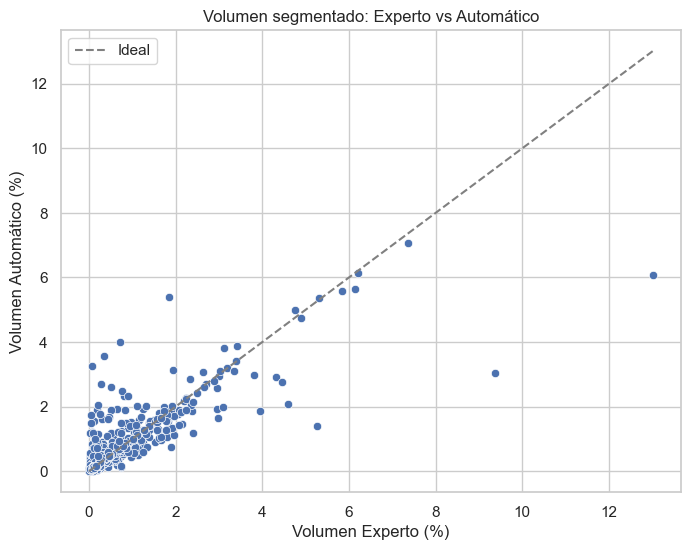

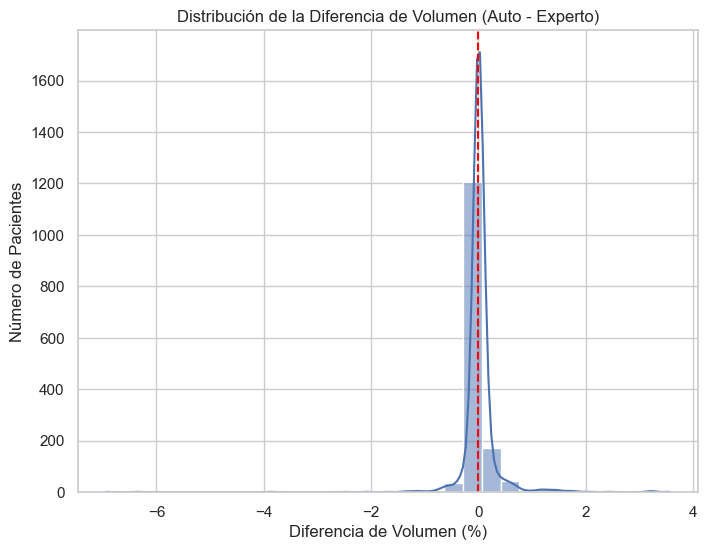

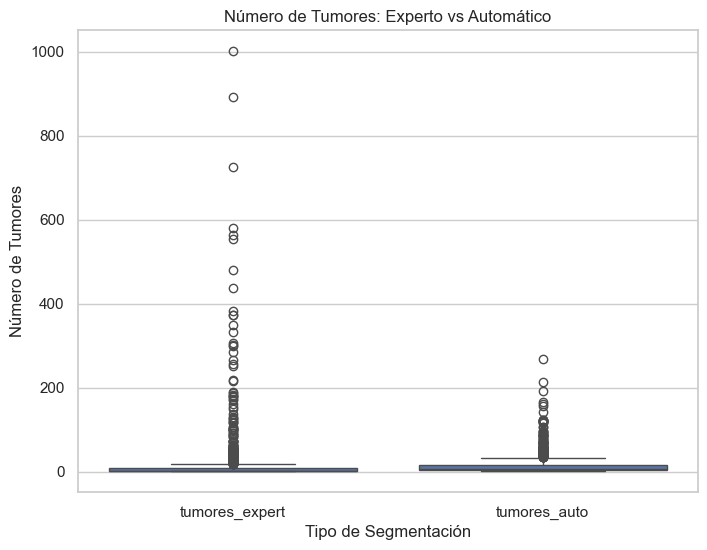

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar CSV con los datos comparados
df_comparado = pd.read_csv('comparacion_expert_auto.csv')

# Estilo de visualización
sns.set(style="whitegrid")

# 1. SCATTER: Volumen experto vs automático
plt.figure(figsize=(8,6))
sns.scatterplot(x='volumen_expert', y='volumen_auto', data=df_comparado)
plt.plot([0, max(df_comparado['volumen_expert'].max(), df_comparado['volumen_auto'].max())],
         [0, max(df_comparado['volumen_expert'].max(), df_comparado['volumen_auto'].max())],
         linestyle='--', color='gray', label='Ideal')
plt.title('Volumen segmentado: Experto vs Automático')
plt.xlabel('Volumen Experto (%)')
plt.ylabel('Volumen Automático (%)')
plt.legend()
plt.show()

# 2. HISTOGRAMA: Diferencia de volumen
plt.figure(figsize=(8,6))
sns.histplot(df_comparado['dif_volumen'], bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribución de la Diferencia de Volumen (Auto - Experto)')
plt.xlabel('Diferencia de Volumen (%)')
plt.ylabel('Número de Pacientes')
plt.show()

# 3. BOXPLOT: Número de tumores
plt.figure(figsize=(8,6))
df_melt = df_comparado.melt(id_vars='paciente', value_vars=['tumores_expert', 'tumores_auto'],
                            var_name='tipo_segmentacion', value_name='num_tumores')
sns.boxplot(x='tipo_segmentacion', y='num_tumores', data=df_melt)
plt.title('Número de Tumores: Experto vs Automático')
plt.xlabel('Tipo de Segmentación')
plt.ylabel('Número de Tumores')
plt.show()


In [ ]:
import pandas as pd

# Cargar el CSV con los datos comparados
df = pd.read_csv('comparacion_expert_auto.csv')

# Función para clasificar visibilidad
def clasificar_visibilidad(n_tumores, volumen):
    if volumen > 0.05 and n_tumores == 1:
        return 'Alta'
    elif volumen < 0.01 or n_tumores > 3:
        return 'Baja'
    else:
        return 'Media'

# Aplicar clasificación a ambas segmentaciones
df['visibilidad_expert'] = df.apply(lambda row: clasificar_visibilidad(row['tumores_expert'], row['volumen_expert']), axis=1)
df['visibilidad_auto'] = df.apply(lambda row: clasificar_visibilidad(row['tumores_auto'], row['volumen_auto']), axis=1)

# Guardar nuevo CSV con visibilidad añadida
output_path = 'comparacion_expert_auto_visibilidad.csv'
df.to_csv(output_path, index=False)
print(df.head())




   paciente  tumores_expert  volumen_expert  tumores_auto  volumen_auto  \
0  duke_001               3        0.023284             3      0.025193   
1  duke_002               3        0.004599             1      0.005384   
2  duke_005              47        0.061568            12      0.059930   
3  duke_009              13        0.026099            23      0.027013   
4  duke_010              21        0.091636             9      0.086703   

   dif_tumores  dif_volumen visibilidad_expert visibilidad_auto  
0            0     0.001909              Media            Media  
1           -2     0.000784               Baja             Baja  
2          -35    -0.001638               Baja             Baja  
3           10     0.000915               Baja             Baja  
4          -12    -0.004933               Baja             Baja  


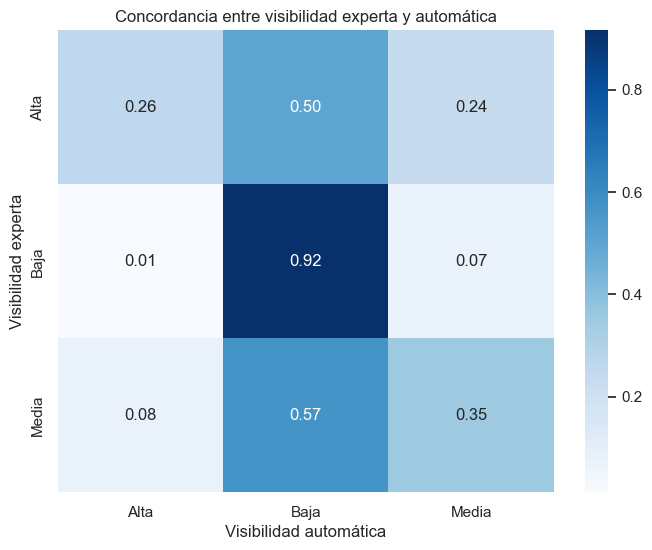

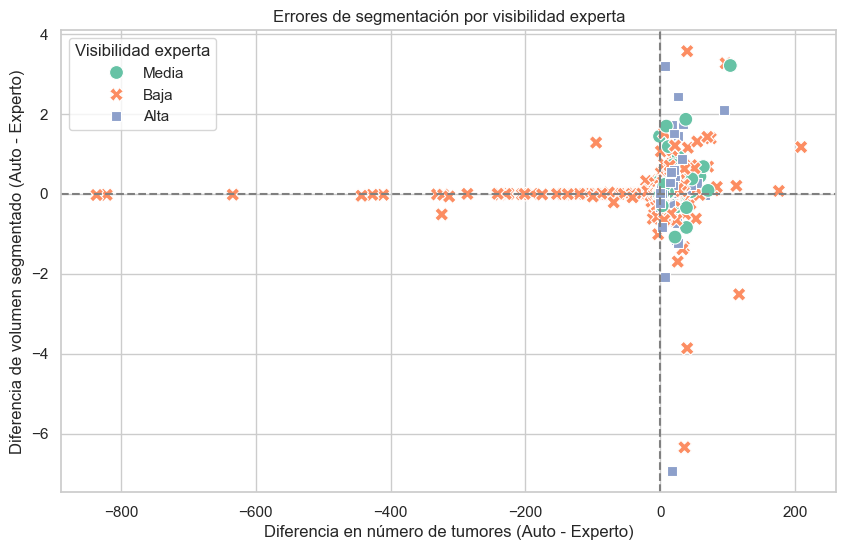

  visibilidad_expert  dif_tumores  dif_volumen
0               Alta       5.3974       0.0287
1               Baja     -13.5386       0.0093
2              Media       5.8685       0.0438


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Configurar estilo visual
sns.set(style="whitegrid")

# 1. Heatmap de concordancia entre visibilidad experta y automática
conf_matrix = pd.crosstab(df['visibilidad_expert'], df['visibilidad_auto'], normalize='index')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title('Concordancia entre visibilidad experta y automática')
plt.xlabel('Visibilidad automática')
plt.ylabel('Visibilidad experta')
plt.show()

# 2. Scatter plot: diferencia de volumen vs diferencia de tumores, coloreado por visibilidad experta
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='dif_tumores', y='dif_volumen', hue='visibilidad_expert', style='visibilidad_expert', palette='Set2', s=100)
plt.axhline(0, linestyle='--', color='gray')
plt.axvline(0, linestyle='--', color='gray')
plt.title('Errores de segmentación por visibilidad experta')
plt.xlabel('Diferencia en número de tumores (Auto - Experto)')
plt.ylabel('Diferencia de volumen segmentado (Auto - Experto)')
plt.legend(title='Visibilidad experta')
plt.grid(True)
plt.show()

# 3. Tabla resumen con medias por visibilidad experta
resumen = df.groupby('visibilidad_expert')[['dif_tumores', 'dif_volumen']].mean().round(4)
resumen.reset_index(inplace=True)
print(resumen)


## 📊 Análisis de Segmentaciones según Visibilidad Tumoral

En este análisis se estudia **cómo varían los errores de la segmentación automática frente a la experta**, dependiendo del nivel de **visibilidad del tumor**.

La **visibilidad** se ha calculado tanto para la segmentación experta como para la automática, basándose en:
- El **volumen tumoral segmentado** (en porcentaje del volumen total).
- El **número de componentes conectadas** (tumores separados).

Se han definido tres niveles de visibilidad:
- **Alta**: Tumor único y de gran tamaño.
- **Media**: Intermedia en número de tumores y volumen.
- **Baja**: Múltiples tumores o volumen muy pequeño.

> En este análisis, tomamos la **visibilidad experta** como referencia para evaluar la calidad de las segmentaciones automáticas. Además, comparamos la clasificación de visibilidad entre ambos métodos para estudiar la concordancia.

---

###  1. Concordancia entre visibilidad experta y automática

- La matriz de confusión muestra cómo se alinean las clasificaciones de visibilidad de ambos métodos.
- La **concordancia es mayor en los casos de baja visibilidad** (92%), lo cual sugiere que el modelo identifica bien estos casos.
- En cambio, para los **tumores de alta visibilidad**, el modelo automático tiende a clasificarlos erróneamente como "media" o incluso "baja", lo cual indica un **sesgo hacia la simplificación**.

---

### 2. Errores de segmentación según visibilidad experta

- Cada punto representa un paciente, mostrando la diferencia entre modelo automático y experto en:
  - Eje X: número de tumores.
  - Eje Y: volumen tumoral.
- Los errores se agrupan según la visibilidad experta:
  - **Baja visibilidad**: Mayor dispersión y errores más extremos.
  - **Media/Alta visibilidad**: Mejores resultados, errores más controlados.

---

### 3. Resumen de errores medios por visibilidad experta

| Visibilidad | ∆ Tumores (Auto - Expert) | ∆ Volumen (%) |
|-------------|----------------------------|----------------|
| Alta        | **+5.40** → sobresegmentación | **+0.0287** |
| Media       | **+5.87** → sobresegmentación | **+0.0438** |
| Baja        | **-13.54** → subsegmentación | **+0.0093** |

- El modelo **subsegmenta tumores** en casos de baja visibilidad (omite focos).
- En tumores de media y alta visibilidad, tiende a **sobresegmentar**, detectando más regiones o extendiendo el volumen.

---

### ✅ Conclusión

> El modelo automático muestra **diferencias claras en rendimiento según la visibilidad del tumor**. Los casos difíciles (baja visibilidad) siguen siendo un reto, lo cual sugiere la necesidad de:
>
> - Mejorar la sensibilidad del modelo.
> - Incluir mecanismos de control de calidad.
> - Aplicar estrategias específicas para tumores pequeños o multifocales.



# Embedding

In [ ]:
import os
import torch
import numpy as np
from monai.networks.nets import resnet
from monai.transforms import (
    Compose, LoadImage, ScaleIntensity,
    Resize, EnsureChannelFirst, ToTensor
)

def extraer_embedding(ruta_imagen, modelo=None, tamaño_destino=(96, 96, 96), device=None):
    """
    Extrae embeddings a partir de imágenes médicas 3D utilizando ResNet3D de MONAI.
    
    Args:
        ruta_imagen (str): Ruta al archivo de imagen 3D (.nii o .nii.gz)
        modelo (torch.nn.Module, optional): Modelo CNN. Si no se pasa, se crea uno nuevo.
        tamaño_destino (tuple, optional): Tamaño final de la imagen (ej. (96,96,96)).
        device (torch.device, optional): GPU o CPU.
    
    Returns:
        np.ndarray: Vector de embedding.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if not os.path.exists(ruta_imagen):
        raise FileNotFoundError(f"No se encontró la imagen: {ruta_imagen}")

    # Transformaciones MONAI
    transforms = Compose([
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(minv=0.0, maxv=1.0),
        Resize(spatial_size=tamaño_destino, mode='trilinear', align_corners=True),
        ToTensor()
    ])

    # Cargar y transformar imagen
    img_tensor = transforms(ruta_imagen).unsqueeze(0).to(device)  # Añade dimensión batch

    # Crear modelo si no se pasó uno
    if modelo is None:
        modelo = resnet.resnet10(
            spatial_dims=3,
            n_input_channels=1,
            pretrained=False,
            num_classes=2
        )
        modelo.fc = torch.nn.Identity()
        modelo = modelo.to(device)

    modelo.eval()
    with torch.no_grad():
        embedding = modelo(img_tensor)
        embedding = embedding.cpu().numpy().flatten()

    return embedding


def procesar_directorio(directorio, modelo=None, tamaño_destino=(96, 96, 96)):
    """
    Procesa todas las imágenes .nii/.nii.gz en un directorio y extrae embeddings.

    Args:
        directorio (str): Ruta del directorio con imágenes.
        modelo (torch.nn.Module): Modelo a usar (opcional).
        tamaño_destino (tuple): Tamaño estándar para las imágenes.

    Returns:
        dict: {nombre_archivo: embedding}
    """
    resultados = {}

    if modelo is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        modelo = resnet.resnet10(
            spatial_dims=3,
            n_input_channels=1,
            pretrained=False,
            num_classes=2
        )
        modelo.fc = torch.nn.Identity()
        modelo = modelo.to(device)

    for archivo in os.listdir(directorio):
        if archivo.endswith(('.nii', '.nii.gz')):
            ruta = os.path.join(directorio, archivo)
            try:
                embedding = extraer_embedding(ruta, modelo=modelo, tamaño_destino=tamaño_destino)
                resultados[archivo] = embedding
                print(f"Procesado: {archivo} → embedding shape: {embedding.shape}")
            except Exception as e:
                print(f"Error al procesar {archivo}: {e}")

    return resultados


def guardar_embeddings(embeddings, ruta_salida):
    """
    Guarda los embeddings en un archivo .npy.

    Args:
        embeddings (dict): Diccionario {nombre_archivo: embedding}
        ruta_salida (str): Ruta para guardar el archivo .npy
    """
    np.save(ruta_salida, embeddings)
    print(f"💾 Embeddings guardados en {ruta_salida}")


# === EJEMPLO DE USO ===
if __name__ == "__main__":
    # Procesar una imagen
    ruta_img = "datos/images/duke_001_0000.nii.gz"
    emb = extraer_embedding(ruta_img)
    print(f"Embedding shape: {emb.shape}")
    print("Embedding vector:", emb)
    
    # Procesar todas las imágenes en un directorio
    # dir_path = "datos/imagenes"
    # embeddings = procesar_directorio(dir_path)
    # guardar_embeddings(embeddings, "resultados/embeddings.npy")


Embedding shape: (512,)
Embedding vector: [7.54118257e-04 1.28246412e-01 6.48979545e-02 3.91372107e-02
 1.28167635e-02 2.06378773e-02 8.23651850e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.27915870e-02 2.49493215e-02
 8.33834801e-03 4.36384678e-02 2.60538422e-03 1.22300899e-02
 7.92536214e-02 2.82259304e-02 1.03040166e-01 1.74808092e-02
 0.00000000e+00 1.19025270e-02 1.58597459e-03 2.73599736e-02
 6.83434382e-02 1.03986405e-01 6.81843013e-02 1.93164276e-04
 1.07946306e-01 1.71572372e-01 4.77751791e-02 2.98115599e-04
 2.04548743e-02 2.49761660e-02 5.79494201e-02 1.09271728e-03
 4.90755134e-04 1.53070912e-01 1.66216925e-01 1.83873903e-03
 9.70317274e-02 0.00000000e+00 4.84956690e-05 5.45393967e-04
 0.00000000e+00 2.17468776e-02 2.82978211e-02 2.54874621e-02
 2.73985555e-03 1.16461135e-01 8.34138971e-03 1.30785480e-02
 5.29978331e-03 0.00000000e+00 7.11484812e-03 0.00000000e+00
 1.89829690e-04 1.58907965e-01 8.32508728e-02 1.76610246e-01
 4.47120816e-02 8.44431967e-02 1.25950873e-

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from monai.networks.nets import resnet
from monai.transforms import (
    Compose, LoadImage, ScaleIntensity,
    Resize, EnsureChannelFirst, ToTensor
)

# -------------------
# FUNCIONES
# -------------------

def extraer_embedding(ruta_imagen, modelo=None, tamaño_destino=(96, 96, 96), device=None):
    """
    Extrae embeddings de una imagen 3D usando ResNet3D.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if not os.path.exists(ruta_imagen):
        raise FileNotFoundError(f"No se encontró la imagen: {ruta_imagen}")

    transforms = Compose([
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(minv=0.0, maxv=1.0),
        Resize(spatial_size=tamaño_destino, mode='trilinear', align_corners=True),
        ToTensor()
    ])

    img_tensor = transforms(ruta_imagen).unsqueeze(0).to(device)  # [B, C, D, H, W]

    if modelo is None:
        modelo = resnet.resnet10(
            spatial_dims=3,
            n_input_channels=1,
            pretrained=False,
            num_classes=2
        )
        modelo.fc = torch.nn.Identity()
        modelo = modelo.to(device)

    modelo.eval()
    with torch.no_grad():
        embedding = modelo(img_tensor)
        embedding = embedding.cpu().numpy().flatten()

    return embedding


def procesar_directorio(directorio, modelo=None, tamaño_destino=(96, 96, 96)):
    """
    Procesa todas las imágenes en un directorio y extrae sus embeddings.
    """
    resultados = {}

    if modelo is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        modelo = resnet.resnet10(
            spatial_dims=3,
            n_input_channels=1,
            pretrained=False,
            num_classes=2
        )
        modelo.fc = torch.nn.Identity()
        modelo = modelo.to(device)

    for archivo in os.listdir(directorio):
        if archivo.endswith(('.nii', '.nii.gz')):
            ruta = os.path.join(directorio, archivo)
            try:
                embedding = extraer_embedding(ruta, modelo=modelo, tamaño_destino=tamaño_destino)
                resultados[archivo] = embedding
                print(f"✅ Procesado: {archivo} → embedding shape: {embedding.shape}")
            except Exception as e:
                print(f"❌ Error al procesar {archivo}: {e}")

    return resultados


def guardar_embeddings_csv(embeddings_dict, ruta_csv):
    """
    Guarda los embeddings en un archivo .csv.
    """
    df = pd.DataFrame.from_dict(embeddings_dict, orient='index')
    df.index.name = 'archivo'
    os.makedirs(os.path.dirname(ruta_csv), exist_ok=True)
    df.to_csv(ruta_csv)
    print(f"💾 Embeddings guardados en {ruta_csv}")


# -------------------
# USO
# -------------------

if __name__ == "__main__":
    # Ruta a tu carpeta de imágenes
    directorio = "datos/image" \
    "s"

    # Extraer embeddings
    embeddings = procesar_directorio(directorio)

    # Guardar en CSV
    guardar_embeddings_csv(embeddings, "resultados/embeddings.csv")


✅ Procesado: duke_001_0000.nii.gz → embedding shape: (512,)
✅ Procesado: duke_001_0001.nii.gz → embedding shape: (512,)
✅ Procesado: duke_001_0002.nii.gz → embedding shape: (512,)
✅ Procesado: duke_001_0003.nii.gz → embedding shape: (512,)
✅ Procesado: duke_001_0004.nii.gz → embedding shape: (512,)
✅ Procesado: duke_002_0000.nii.gz → embedding shape: (512,)
✅ Procesado: duke_002_0001.nii.gz → embedding shape: (512,)
✅ Procesado: duke_002_0002.nii.gz → embedding shape: (512,)
✅ Procesado: duke_002_0003.nii.gz → embedding shape: (512,)
✅ Procesado: duke_005_0000.nii.gz → embedding shape: (512,)
✅ Procesado: duke_005_0001.nii.gz → embedding shape: (512,)
✅ Procesado: duke_005_0002.nii.gz → embedding shape: (512,)
✅ Procesado: duke_005_0003.nii.gz → embedding shape: (512,)
✅ Procesado: duke_009_0000.nii.gz → embedding shape: (512,)
✅ Procesado: duke_009_0001.nii.gz → embedding shape: (512,)
✅ Procesado: duke_009_0002.nii.gz → embedding shape: (512,)
✅ Procesado: duke_009_0003.nii.gz → embe